<a href="https://colab.research.google.com/github/austinbennysmith/CMIP6/blob/main/NAO_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PCA analysis for studying the Winter North Atlantic Oscillation**

The [North Atlantic Oscillation](https://en.wikipedia.org/wiki/North_Atlantic_oscillation) is a mode of climate variability in the North Atlantic with a wide variety of effects throughout the region including impacts on storm tracks, sea level, and ecology. The NAO is manifested as a difference in sea level pressure between Northern air masses (roughly over Iceland) and southern air (roughly over the Azores).

Traditionally, a NAO index has simply been calculated from the normalized sea level pressure difference between Reykjavic, Iceland and Lisbon, Portugal. More details on this calculation are found [here](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-station-based). A more useful definition of the NAO is based on Principal Component Analysis (or in the geophysics parlance, Empirical Orthogonal Function Analysis). PCA of North Atlantic Sea Level Pressure allows one to see both the dominant pattern of spatial variability and the change in the strength of that pattern across time. This notebook demonstrates PCA analysis with a sea level pressure dataset generated by a climate model, available through the cloud as part of the Coupled Model Intercomparison Project (CMIP6).

This code is partly based on the following link: http://nicolasfauchereau.github.io/climatecode/posts/eof-analysis-with-scikit-learn/

Note: in actual applications of PCA to climate data, the data should be weighted by the area of the grid cells, but I felt this weighting would be an unnecessary complication here. So the results here are slightly innacurate.

In [ ]:
## Importing the necessary modules:

!pip install fsspec
# !pip install netCDF4
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
# !pip install eofs
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
# from eofs.xarray import Eof
from nc_time_axis import NetCDFTimeConverter, CalendarDateTime
import cftime
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import pca

I use [Pangeo](https://pangeo-data.github.io/pangeo-cmip6-cloud/) to access the climate model data. The files are organized in a csv format:

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv') 
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tauu,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


Next I choose the Sea Level Pressure variable ('psl') in a 'historical' simulation that simulates the years 1850-2014. The table_id=='Amon' specification asks for monthly data, and I am only looking at data from the CESM2 model. Printing the length of the resulting dataset gives me the number of runs available with these conditions (there are 11). I will look at just one simulation.

In [ ]:
psl_historical = df.query("variable_id == 'psl' & experiment_id == 'historical' & table_id == 'Amon' & source_id == 'CESM2'")
print(len(psl_historical))

11


In the following cell I open the actual data. I initially open it as an Xarray Dataset (this is the xr.open_zarr command) and use xarray to slice the dataset so that I have the latitude and longitude range of the NAO (latitude 20-80N, longitude 90W-40E). I also restrict it to only the Winter months (December, January, February). This cell converts the Xarray Dataset to a numpy array, and the rest of the notebook will not use Xarray, but Xarray is worth discussing a bit because of how useful it is for climate applications.

[Xarray](http://xarray.pydata.org/en/stable/) is a package based on Pandas and is very useful for working with climate data stored as NetCDF files. [NetCDF](https://www.unidata.ucar.edu/software/netcdf/?_ga=2.77896087.2016730849.1613498586-174498609.1613498586) (Network Common Data Form) files can efficiently store multidimensional data such as the Sea Level Pressure data considered here (stored in latitude, longitude, and time dimensions). NetCDF files also contain attributes and metadata and are thus self-describing. Working with NetCDF files using Xarray (by reading them using xr.open_dataset or similar functions) makes it very easy to slice the files the way you want and perform a variety of operations on them.

An alternative to Xarray is the NetCDF4 module, though it is less versatile.

In [ ]:
# Accessing the file, getting it to just the lats and lons I want:
zstore = psl_historical.zstore.values[0] # By choosing index 0, I am looking at just the first of 11 available simulations meeting my specifications
mapper = fsspec.get_mapper(zstore)
ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Opening the file using Xarray
psl = ds.psl.sel(lat=slice(20,80)) # Choosing latitudes 20-80N
psl = psl.where((ds.lon >= 270) | (ds.lon <= 40), drop=True) # Choosing longitudes 90W-40E
lat = ds.lat.sel(lat=slice(20,80)) # Defining a latitude variable
lon = ds.lon.where((ds.lon >= 270) | (ds.lon <= 40), drop=True) # Defining a longitude variable

# The following function tests whether a given data point is in the Winter season:
def is_djf(month): # source: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
  return (month>=12) | ((month>=1) & (month<=2)) # The | symbol is an OR operator
psl_djf = psl.sel(time=is_djf(psl['time.month'])) # I define a psl_djf Xarray object that applies the is_djf function to the psl Dataset. psl['time.month'] is an Xarray DataArray containing the month values of the time dimension. This is an example of how convenient Xarray is: it's very easy to slice the arrays exactly the way you want.
psl_djf_np = psl_djf.values # Here I convert the Xarray object to a numpy array. psl_djf is an Xarray DataArray, but psl_djf.values is a numpy object

### **Scree Plot**
Here I apply Principal Component analysis and make a Scree Plot. The graph shows that the first PC explains a bit over 40% of the variability.

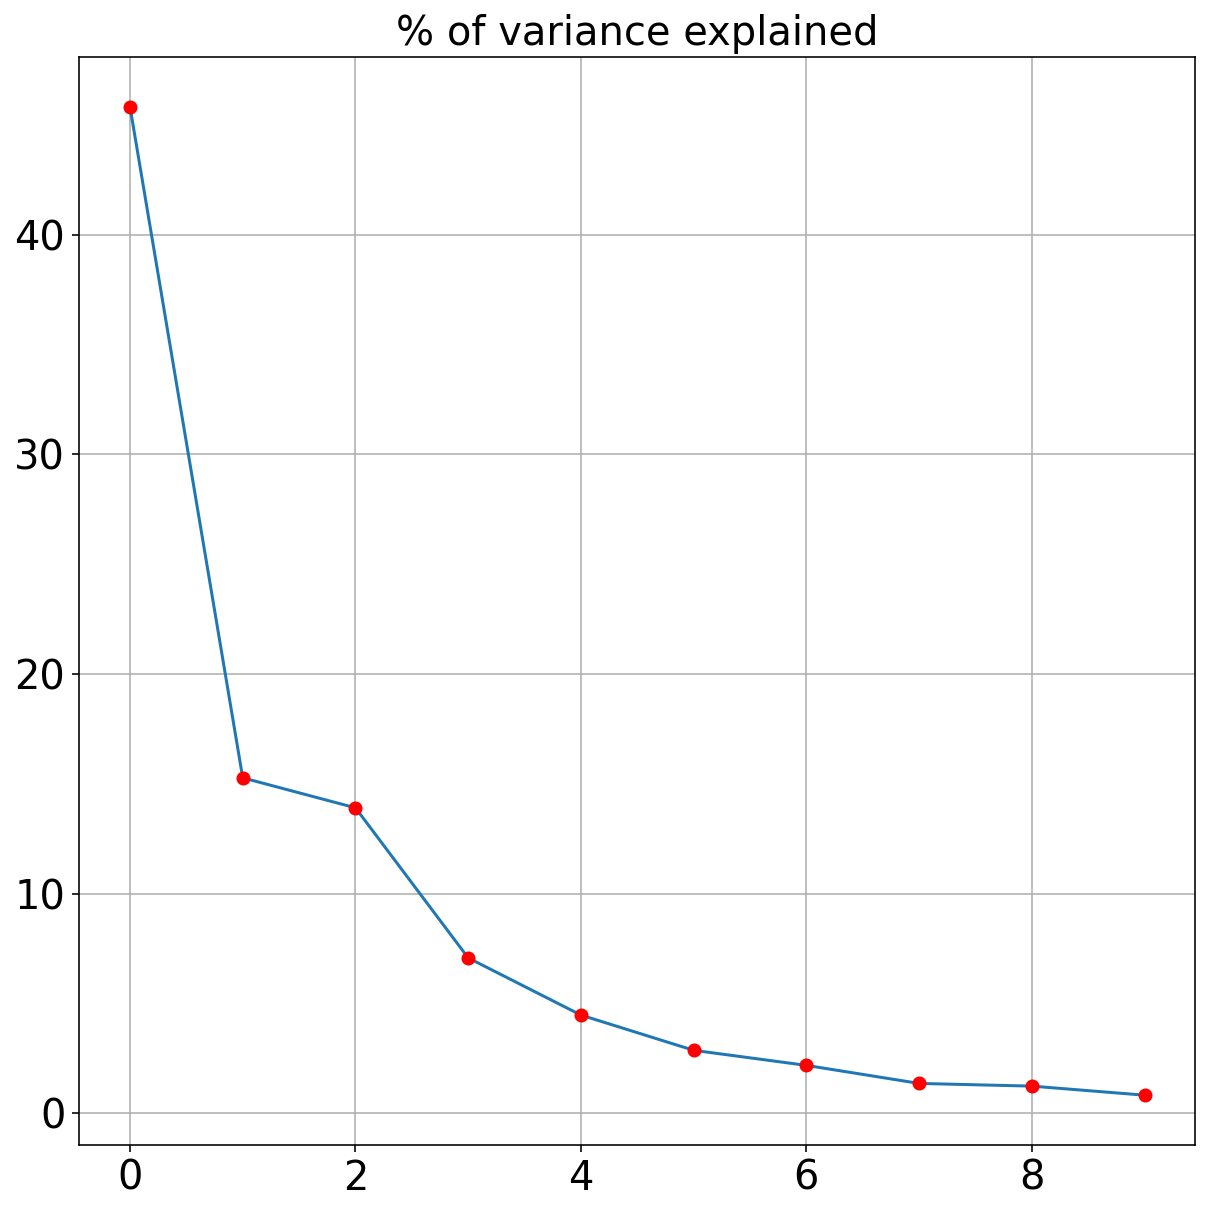

In [ ]:
tlength = len(psl_djf.time)
psl2d = np.reshape(psl_djf_np, (tlength, len(lon)*len(lat)))

skpca = pca.PCA()
skpca.fit(psl2d)

f, ax = plt.subplots(figsize=(10,10))
ax.plot(skpca.explained_variance_ratio_[0:10]*100)
ax.plot(skpca.explained_variance_ratio_[0:10]*100,'ro')
ax.set_title("% of variance explained", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid()

## **Spatial and Temporal Patterns**

I use sklearn to get the Principal Components:

In [ ]:
PCs = skpca.transform(psl2d)
print(PCs.shape)
len(PCs)
PCs

(495, 495)


array([[-5.1891320e+04, -1.2853178e+04, -3.1236775e+03, ...,
         2.0599983e+01,  9.0000992e+00,  2.6373749e+00],
       [-2.2756814e+04, -5.2381216e+03, -2.4276748e+04, ...,
         1.9887218e+00,  7.4130735e+00,  2.7992077e+00],
       [-2.2460633e+04, -6.8777549e+03,  1.3458458e+04, ...,
        -3.5642700e+00,  9.2892838e+00,  2.4893866e+00],
       ...,
       [-2.4063240e+04, -5.9212837e+03, -5.5978794e+03, ...,
         1.4241390e+01,  7.9066563e+00,  2.8060341e+00],
       [-2.0716086e+04,  1.0180553e+04, -1.0027743e+04, ...,
         1.6625990e+01,  2.3024279e+01,  2.6190681e+00],
       [ 1.7640369e+04, -2.9596037e+04,  2.7819016e+03, ...,
        -1.2671238e+01, -1.0570036e+01,  2.7065849e+00]], dtype=float32)

Next the Pcs are scaled using the StandardScaler().

In [ ]:
scaler_PCs = StandardScaler()
scaler_PCs.fit(PCs)
PCs_std = scaler_PCs.transform(PCs)
PCs_std.shape

(495, 495)

Below I use skpca.components to get the Empirical Orthogonal Functions, or the dominant patterns of spatial variability (these will be mapped shortly). I also put the data into a Pandas Dataframe.

In [ ]:
EOFs = skpca.components_
PCdf = pd.DataFrame(PCs_std, index = psl_djf.time, \
                    columns = ["EOF%s" % (x) for x in range(1, PCs_std.shape[1] +1)])
PCdf.head()

,EOF1,EOF2,EOF3,EOF4,EOF5,EOF6,EOF7,EOF8,EOF9,EOF10,EOF11,EOF12,EOF13,EOF14,EOF15,EOF16,EOF17,EOF18,EOF19,EOF20,EOF21,EOF22,EOF23,EOF24,EOF25,EOF26,EOF27,EOF28,EOF29,EOF30,EOF31,EOF32,EOF33,EOF34,EOF35,EOF36,EOF37,EOF38,EOF39,EOF40,...,EOF456,EOF457,EOF458,EOF459,EOF460,EOF461,EOF462,EOF463,EOF464,EOF465,EOF466,EOF467,EOF468,EOF469,EOF470,EOF471,EOF472,EOF473,EOF474,EOF475,EOF476,EOF477,EOF478,EOF479,EOF480,EOF481,EOF482,EOF483,EOF484,EOF485,EOF486,EOF487,EOF488,EOF489,EOF490,EOF491,EOF492,EOF493,EOF494,EOF495
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1850-01-15 12:00:00,-1.549812,-0.664959,-0.169358,-0.222693,-1.241279,0.408261,-0.027740,-0.715858,-1.171630,-1.705371,-1.148615,-0.169840,-0.100327,0.582906,1.105868,0.266462,1.440013,-0.794527,-1.469615,-0.719821,-0.196853,-0.933603,0.440380,-0.023251,1.961824,1.234302,0.275839,1.097052,0.026838,0.538875,0.828046,0.135800,1.776886,-0.832920,-0.671298,0.582509,0.331766,-0.131959,0.905521,-0.768250,...,0.856036,-0.262116,1.809433,1.053424,1.385447,2.363706,0.640433,0.763611,0.636606,1.461596,-0.465324,0.002826,-1.831382,-1.136385,-0.467910,-0.424120,0.259517,-2.413198,1.203723,1.632210,-0.346476,-0.646805,-1.557380,-0.417283,-0.568069,-0.000775,-1.118273,-0.634806,1.475244,0.659083,-0.871858,-0.281470,0.403605,-0.986083,-1.135604,-0.944752,0.719737,1.666954,0.761698,-0.916522
1850-02-14 00:00:00,-0.679667,-0.270995,-1.316208,1.351915,1.022782,-0.119990,0.700067,-0.105867,-0.789031,0.715594,-0.556534,1.079369,-1.183802,1.095061,0.133589,0.109144,0.058629,0.419691,1.468868,0.068334,-0.302226,-1.466839,-1.005690,-1.120235,0.063226,0.047388,1.264304,-0.127437,-0.747180,1.212916,0.417475,1.357951,-1.646732,0.552693,0.882563,-0.597915,-0.224682,1.721261,-1.543404,0.066599,...,-0.679149,1.289453,-0.116067,-0.905612,0.923919,0.048837,0.130585,0.062486,-0.222534,-0.973241,-0.474618,-0.549018,-0.657884,-0.595327,-1.360119,-1.119359,0.902314,0.603388,-1.056094,0.003221,-1.017783,-0.343463,0.715899,-0.324927,0.591197,-1.516548,-0.458430,-1.767108,0.505376,-0.666588,0.558603,-0.269420,-1.588879,0.570223,0.977627,-0.746836,1.696283,0.160277,0.627704,1.234610
1850-12-15 12:00:00,-0.670822,-0.355821,0.729671,1.240745,0.039792,1.480685,-0.485406,1.651984,1.132139,0.722799,0.044288,-1.655053,0.482831,-0.613428,0.911518,-0.367619,-1.428251,1.131577,-0.647781,0.159686,-0.137020,0.327661,1.083759,0.893399,0.079834,1.110906,-0.400400,-1.717070,-0.648119,0.728412,1.130285,-0.142411,0.179471,-0.083590,0.421655,0.882962,-0.119415,-1.451337,0.287261,-0.879059,...,0.172168,0.191477,0.504581,1.741285,-0.953974,-0.293531,0.780939,-0.675104,1.807634,1.098059,-1.150051,1.614103,1.180206,0.890508,-0.546861,-1.216525,-0.783310,-0.702113,-1.430485,-1.006849,0.850858,0.661370,-2.459963,0.622869,-0.052769,0.584030,-1.560265,-0.620518,-0.292005,0.043172,-0.404774,0.503214,1.009726,1.737993,-0.938806,-1.162554,-0.953187,-0.289266,0.786114,-2.883629
1851-01-15 12:00:00,-0.505129,0.495867,-1.335619,-0.900930,0.569703,-1.049116,1.800291,0.315340,-0.537131,-1.150143,0.049480,-1.503727,0.080130,-0.151173,0.362431,-0.994512,0.200169,1.289739,0.569353,0.688302,0.666321,2.008693,-0.701883,-0.842192,-0.105795,-0.613388,2.416440,-0.209654,-0.700391,1.204405,0.083785,-0.692291,-0.329323,-0.637647,0.553379,-1.119976,-1.376852,2.140709,0.194301,-0.683910,...,-1.090773,0.724581,0.789880,-0.741671,-0.237138,-0.650166,-1.308071,0.077902,0.669339,-0.557381,-0.076250,0.889615,-0.544597,-0.569348,1.944652,1.286581,-1.533804,1.510990,0.751687,0.677227,-0.645431,-1.006859,-0.074030,-1.090758,2.019264,2.008675,1.098952,-2.672931,0.605537,-1.983438,1.555804,1.399091,-0.009068,-0.218902,-0.554421,-1.259641,-1.359136,1.504864,-2.008848,0.958553
1851-02-14 00:00:00,-1.523727,0.306989,-1.351971,-0.823706,-0.109659,0.332527,0.416745,0.133899,-0.948606,-0.610847,0.559107,0.355949,-0.191333,1.421831,0.407703,-0.608777,0.044910,0.289064,0.984530,-0.081264,0.181428,2.009218,-2.476994,1.567382,0.020235,-1.

Next I plot the EOFs. The first EOF shows the SLP dipole that defines the NAO. Seeing this pattern is a sanity check that the analysis worked.

/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


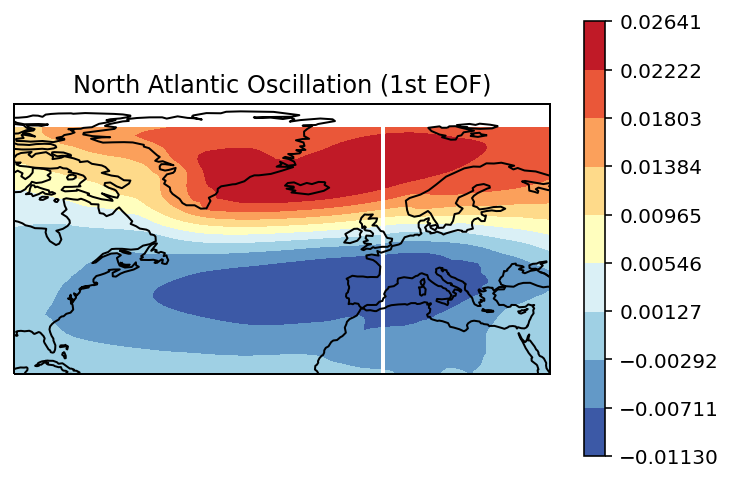

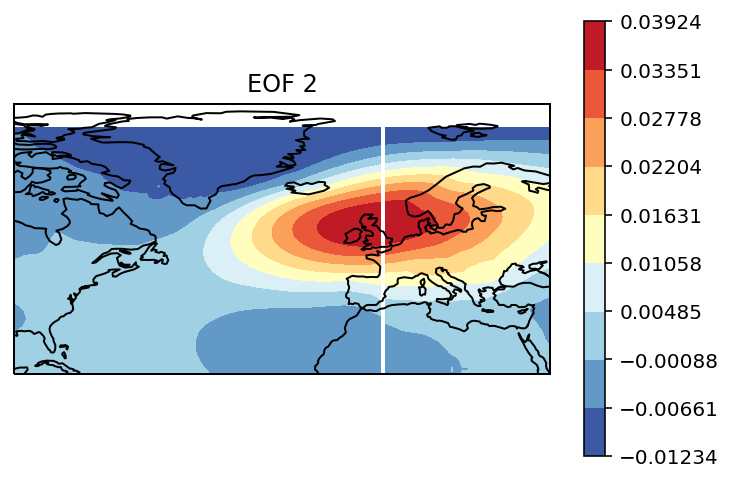

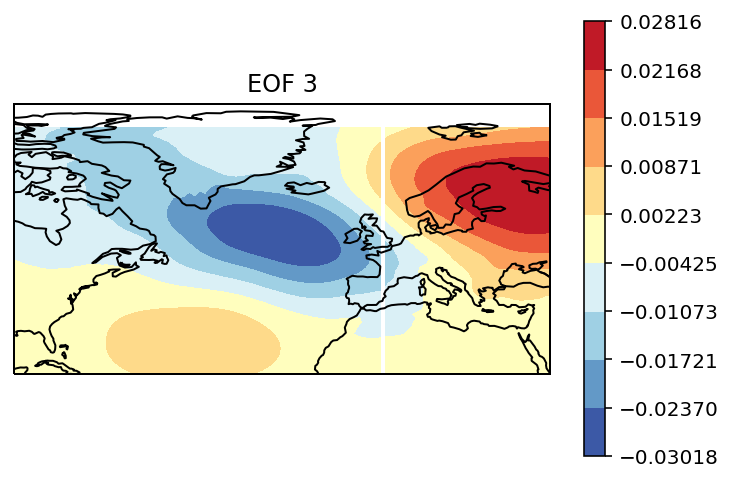

In [ ]:
EOFsPlotting = EOFs.reshape((len(PCs), len(lat), len(lon)))

maxes = []
mins = []
for i in range(len(EOFs)):
  maxes.append(max(EOFs[i]))
  mins.append(min(EOFs[i]))

for i in range(3):
  levels = np.linspace(min(EOFs[i]), max(EOFs[i]), 10)
  ax = plt.axes(projection=ccrs.PlateCarree())
  cs=ax.contourf(lon, lat, EOFsPlotting[i, :, :],levels,
                transform=ccrs.PlateCarree(),
                cmap=plt.cm.RdYlBu_r)
  ax.coastlines()
  ax.set_extent([-90, 40, 20, 80]) # longitude latitude extent
  plt.colorbar(cs, orientation='vertical') # color map
  if i==0:
    plt.title('North Atlantic Oscillation (1st EOF)')
  else:
    plt.title('EOF '+str(i+1))
  plt.show()

Next I would like to make a graph showing how the NAO changed over time in the simulation. It will be easier to see trends if we take a decadal moving average, so the following cell defines a function for taking the moving average of a time series.

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
PCdf.to_csv('./NAO.csv') # Converting the Pandas DataFrame to a CSV file to make plotting more convenient

Plotting the time series of the NAO Index I've defined:

(the x-axis is in months 1850-2014, but only includes DJF months)

Text(0.5, 1.0, 'NAOI 1850-2014 (simulation)')

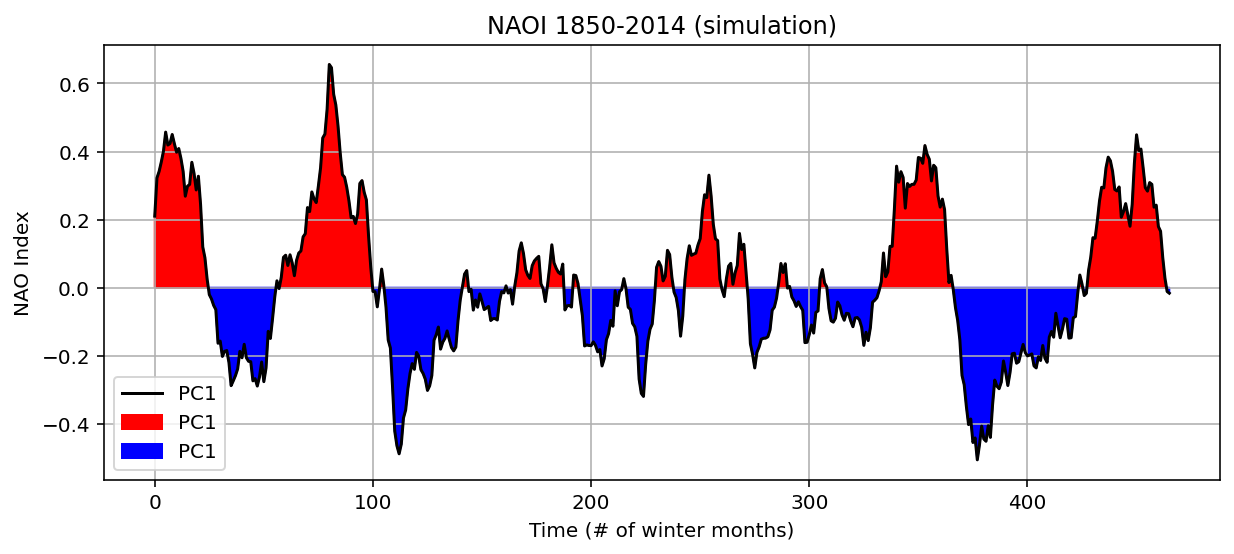

In [17]:
f, ax = plt.subplots(figsize=(10,4))
x = np.arange(466)
y = np.arange(len(PCdf.iloc[:, 0].values))
x = np.arange(466)
ax.plot(x, moving_average(PCdf.iloc[:, 0].values, 30), color='k', label='PC1') # Here I take a moving average across 30 points to get a decadal moving average. This makes sense because the DJF season has 3 months, so there are 30 months per 10 years.
ax.fill_between(x, 0, moving_average(PCdf.iloc[:, 0].values, 30), where=moving_average(PCdf.iloc[:, 0].values, 30)>0, color='r', label='PC1')
ax.fill_between(x, 0, moving_average(PCdf.iloc[:, 0].values, 30), where=moving_average(PCdf.iloc[:, 0].values, 30)<0, color='b', label='PC1')
ax.grid('off')
ax.legend(loc='best');
ax.set_xlabel('Time (# of winter months)')
ax.set_ylabel('NAO Index')
ax.set_title('NAOI 1850-2014 (simulation)')